In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:

import random

import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array

import warnings
warnings.filterwarnings('ignore')

In [ ]:
class Config:
    """ Model and training settings """
     #Data direction
    data_dir = ("/drive/input/fer2013")
    # Image transactions
    IMG_HEIGHT = 48
    IMG_WIDTH = 48
    IMG_CHANNELS = 1

    # TRAINING parameters
    BATCH_SIZE=32
    EPOCHS=50
    LEARNING_RATE=0.0001

    #Categories
    CLASSES=['angry', 'disgust',"fear","happy","neutral","sad","surprise"]
    NUM_CLASSES=len(CLASSES)

    # Saving paths
    MODEL_SAVE_PATH="fer_2013_model.h5"
    WEIGHTS_SAVE_PATH="fer_2013_weights.h5"
    HISTORY_SAVE_PATH="training_history.npy"

config=Config()

In [ ]:
# ==============================
# 3. Data preparation with Data Augmentation
# ==============================
def create_data_generators():
    TRAIN_DIR = os.path.join(config.data_dir, 'train')

    TEST_DIR = os.path.join(config.data_dir ,"test")


    # Training data generator with multiple optimizations
    train_datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 10,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        shear_range = 0.1,
        horizontal_flip = True,
        fill_mode  = "nearest",
        validation_split = 0.2)

    # Validation & Test generator (just rescale)
    test_datagen  = ImageDataGenerator(rescale=1./255)

    # Training generator
    train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size = (config.IMG_HEIGHT,config.IMG_WIDTH),
    color_mode  = "grayscale",
    batch_size  = config.BATCH_SIZE,
    class_mode  = "categorical",
    shuffle     = True ,
    seed        = 42, #To ensure sample stability between sessions.
    subset="training"
    )

    # Validation generator (from same training dir using validation_split)

    validation_generator=train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size = (config.IMG_HEIGHT,config.IMG_WIDTH),
    color_mode = "grayscale",
    batch_size = config.BATCH_SIZE,class_mode="categorical",
    shuffle    = False,
    seed       = 42 ,      #To ensure sample stability between sessions.
     subset="validation"
     )
    test_generator = test_datagen.flow_from_directory(
        TEST_DIR,
        target_size = (config.IMG_HEIGHT,config.IMG_WIDTH),
        color_mode = "grayscale",
        batch_size = config.BATCH_SIZE,
        class_mode = "categorical",
        shuffle    = False,


            )

    return train_generator ,validation_generator,test_generator


In [ ]:
# ==============================
# 4. Building a Professional CNN Model
# ==============================
def build_cnn_model():
    model=models.Sequential([
        #Block 1 -Feature extraction
        layers.Conv2D(32,(3, 3),activation="relu",kernel_initializer='he_normal',padding="same",
                      input_shape=(config.IMG_HEIGHT,config.IMG_WIDTH,config.IMG_CHANNELS)
                     ),
        layers.BatchNormalization(),
        layers.Conv2D(32,(3, 3),activation="relu",kernel_initializer='he_normal',padding="same",),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),#Reducing spatial dimension
        layers.Dropout(0.25),
        # Block 2
        layers.Conv2D(64,(3, 3),activation="relu",kernel_initializer='he_normal',padding="same"),
        layers.BatchNormalization(),
        layers.Conv2D(64,(3, 3),activation="relu",kernel_initializer='he_normal',padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.25),
        # Block 3
        layers.Conv2D(128,(3, 3),activation="relu",kernel_initializer='he_normal',padding="same"),
        layers.BatchNormalization(),
        layers.Conv2D(128,(3, 3),activation="relu",kernel_initializer='he_normal',padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.30),

        # Flatten + Dense - Classifier
        layers.Flatten(),

        layers.Dense(256,activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.40),
        # output layer
        layers.Dense(config.NUM_CLASSES,activation="softmax")
        ])
    return model


In [ ]:
# ==============================
# 5. Assemble the Model
# =================================
def compile_model(model):
     optimizer=optimizers.Adam(learning_rate=config.LEARNING_RATE)
     model.compile(optimizer=optimizer,loss="categorical_crossentropy",
                  metrics=["accuracy",
                           tf.keras.metrics.Precision(),
                           tf.keras.metrics.Recall(),
                           tf.keras.metrics.AUC()

                          ])
     return model



In [ ]:
# ==============================
# 6. Callbacks
# ==============================

def create_callbacks():
    return [
        callbacks.ModelCheckpoint(config.MODEL_SAVE_PATH, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1),
        callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1),
        callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
        callbacks.CSVLogger(config.HISTORY_SAVE_PATH),
    ]

In [ ]:
# ==============================
# 7. Model Training
# ==============================

def train_model(model, train_gen, val_gen, cb_list):
    print("\n🚀 Starting training...\n")
    history = model.fit(
    train_gen,
    epochs=config.EPOCHS,
    validation_data=val_gen,
    callbacks=cb_list,
    verbose=1
    )
    np.save(config.HISTORY_SAVE_PATH , history.history)
    print(f"\n✅ Training complete! Best val_accuracy: {max(history.history['val_accuracy']):.4f}")
    # ==============================
    # Drawing Training and Accuracy Curves
    # ==============================
    # Accuracy
    plt.figure(figsize=(8,5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Loss
    plt.figure(figsize=(8,5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return history

In [ ]:

def predict_and_analyze(model, test_gen):
    print("\n🚀 Prediction on test data...\n")

   #Category prediction
    y_pred_prob = model.predict(test_gen)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = test_gen.classes

    # Classification Report
    print("\n📄 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=config.CLASSES))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=config.CLASSES,
                yticklabels=config.CLASSES)
    plt.title('📊 Confusion Matrix')
    plt.xlabel("Predicted")
    plt.ylabel('Actual')
    plt.show()
    plt.tight_layout()


In [ ]:
def evaluate_model(model, test_gen):
    print("\n✅ Evaluating model...\n")

    results = model.evaluate(test_gen, verbose=1)

    # Associate results with metrics names
    metrics_names = model.metrics_names  # ['loss', 'accuracy', 'precision', 'recall', 'auc']
    results_dict = dict(zip(metrics_names, results))

    print("\n📊 Test Results:")
    for name, value in results_dict.items():
        print(f"{name.capitalize()}: {value:.4f}")

    return results_dict.get('accuracy', None)

In [ ]:
# ==============================
# Main function for CNN training and evaluation
# ==============================
def main():
    print("\n" + "="*60)
    print(" CNN Model for Facial Emotion Recognition ")
    print("="*60 + "\n")

    # ------------------------------
    # Data preparation
    # ------------------------------
    # train_gen, val_gen, test_gen are Keras ImageDataGenerators
    train_gen, val_gen, test_gen = create_data_generators()

    # ------------------------------
    # Build and compile the CNN model
    # ------------------------------
    # build_cnn_model() returns the model architecture
    # compile_model() compiles it with optimizer, loss, and metrics
    model = compile_model(build_cnn_model())

    # ------------------------------
    # Train the model
    # ------------------------------
    # train_model() fits the model on training data and validates on val_gen
    history = train_model(model, train_gen, val_gen, create_callbacks())

    # ------------------------------
    # Evaluate the model
    # ------------------------------
    # Evaluate on the test set
    evaluate_model(model, test_gen)

    # ------------------------------
    # Make predictions and analyze results
    # ------------------------------
    predict_and_analyze(model, test_gen)

    # ------------------------------
    # Save the trained model
    # ------------------------------
    model.save(config.MODEL_SAVE_PATH)
    print(f"\n✅ Model saved at: {config.MODEL_SAVE_PATH}")


In [ ]:
# ==============================
# Display some sample images from the dataset
# ==============================

import os
import random
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img

# Number of images to display
num_samples = 9

# Training directory path
TRAIN_DIR = os.path.join(config.data_dir, 'train')

# Get all classes
classes = sorted(os.listdir(TRAIN_DIR))
samples = []

# Pick one random image from each class (up to num_samples)
for cls in classes[:num_samples]:
    cls_dir = os.path.join(TRAIN_DIR, cls)
    cls_imgs = [img for img in os.listdir(cls_dir) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if cls_imgs:
        img_path = os.path.join(cls_dir, random.choice(cls_imgs))
        samples.append((img_path, cls))

# Plot selected images
plt.figure(figsize=(8, 8))
for i, (img_path, cls) in enumerate(samples):
    img = load_img(img_path, color_mode='grayscale', target_size=(config.IMG_HEIGHT, config.IMG_WIDTH))
    plt.subplot(3, 3, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(cls)
    plt.axis('off')

plt.tight_layout()
plt.show()




FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/fer2013/train'

In [ ]:

# ==============================
# 11. Run program
# ==============================
if __name__ == "__main__":
    # Run the main training and evaluation pipeline
    main()

    # Example: single image prediction (update the path to your image)
    #predict_single_image(
        #model_path=config.MODEL_SAVE_PATH,
        #image_path='path/to/your/image.jpg'  # <- replace with your actual image path
    #)


In [ ]:
import tensorflow as tf
from tensorflow.keras import models
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Define the Config class locally to ensure 'config' is available
class Config:
    """ Model and training settings """
    #Data direction
    data_dir = ("/content/drive/MyDrive/Dataset/Images") # Adjusted path for dataset
    # Image transactions
    IMG_HEIGHT = 48
    IMG_WIDTH = 48
    IMG_CHANNELS = 1

    # TRAINING parameters
    BATCH_SIZE=32
    EPOCHS=50
    LEARNING_RATE=0.0001

    #Categories
    CLASSES=['angry', 'disgust',"fear","happy","neutral","sad","surprise"]
    NUM_CLASSES=len(CLASSES)

    # Saving paths
    MODEL_SAVE_PATH="/content/drive/MyDrive/Deep_learning/Multimodal_Dataset/fer_2013_model.h5"
    WEIGHTS_SAVE_PATH="fer_2013_weights.h5"
    HISTORY_SAVE_PATH="training_history.npy"

config=Config()

# ============================== # 3. Data preparation with Data Augmentation # ==============================
def create_data_generators():
    actual_data_dir = config.data_dir # Default from Config class
    # The previous cell downloaded to '/content/datasets' and unzipped it.
    # So, the actual path might be '/content/datasets/fer2013' if 'fer2013' is the root folder inside the zip.
    # Let's adjust data_dir in config if it's not pointing correctly based on download.
    # For this specific run, let's make sure it looks for the correct path.
    # The previous code had a check, but now config.data_dir is directly set to the correct path.

    TRAIN_DIR = os.path.join(actual_data_dir, 'train')
    TEST_DIR = os.path.join(actual_data_dir ,"test")

    # Check if directories exist before proceeding
    if not os.path.exists(TRAIN_DIR) or not os.path.exists(TEST_DIR):
        print(f"Error: Training or Test directory not found. Please ensure dataset is correctly extracted at {actual_data_dir}.")
        # Return empty generators or raise an error
        raise FileNotFoundError(f"Required data directories not found at {TRAIN_DIR} and {TEST_DIR}")

    # Training data generator with multiple optimizations
    train_datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 10,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        shear_range = 0.1,
        horizontal_flip = True,
        fill_mode  = "nearest",
        validation_split = 0.2)

    # Validation & Test generator (just rescale)
    test_datagen  = ImageDataGenerator(rescale=1./255)

    # Training generator
    train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size = (config.IMG_HEIGHT,config.IMG_WIDTH),
    color_mode   = "grayscale",
    batch_size  = config.BATCH_SIZE,
    class_mode  = "categorical",
    shuffle      = True ,
    seed        = 42, #To ensure sample stability between sessions.
    subset="training"
    )

    # Validation generator (from same training dir using validation_split)
    validation_generator=train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size = (config.IMG_HEIGHT,config.IMG_WIDTH),
    color_mode = "grayscale",
    batch_size = config.BATCH_SIZE,class_mode="categorical",
    shuffle    = False,
    seed       = 42 ,      #To ensure sample stability between sessions.
     subset="validation"
     )
    test_generator = test_datagen.flow_from_directory(
        TEST_DIR,
        target_size = (config.IMG_HEIGHT,config.IMG_WIDTH),
        color_mode = "grayscale",
        batch_size = config.BATCH_SIZE,
        class_mode = "categorical",
        shuffle     = False
            )

    return train_generator ,validation_generator,test_generator

def evaluate_model(model, test_gen):
    print("\n✅ Evaluating model...\n")

    results = model.evaluate(test_gen, verbose=1)

    # Associate results with metrics names
    metrics_names = model.metrics_names  # ['loss', 'accuracy', 'precision', 'recall', 'auc']
    results_dict = dict(zip(metrics_names, results))

    print("\n📊 Test Results:")
    for name, value in results_dict.items():
        print(f"{name.capitalize()}: {value:.4f}")

    return results_dict.get('accuracy', None)

def predict_and_analyze(model, test_gen):
    print("\n🚀 Prediction on test data...\n")

   #Category prediction
    y_pred_prob = model.predict(test_gen)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = test_gen.classes

    # Classification Report
    print("\n📄 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=config.CLASSES))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=config.CLASSES,
                yticklabels=config.CLASSES)
    plt.title('📊 Confusion Matrix')
    plt.xlabel("Predicted")
    plt.ylabel('Actual')
    plt.show()
    plt.tight_layout()

print("\n" + "="*60)
print(" Using Saved Model for Facial Emotion Recognition Testing ")
print("="*60 + "\n")

# 1. Load the pre-trained model
try:
    loaded_model = models.load_model(config.MODEL_SAVE_PATH)
    print(f"✅ Model '{config.MODEL_SAVE_PATH}' loaded successfully.")
except Exception as e:
    print(f"❌ Error loading model '{config.MODEL_SAVE_PATH}': {e}")
    print("Please ensure the model file exists and the path is correct.")
    exit()


 Using Saved Model for Facial Emotion Recognition Testing 



✅ Model '/content/drive/MyDrive/Deep_learning/Multimodal_Dataset/fer_2013_model.h5' loaded successfully.



 Using Saved Model for Facial Emotion Recognition Testing 



✅ Model '/content/drive/MyDrive/Deep_learning/Multimodal_Dataset/fer_2013_model.h5' loaded successfully.
Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
✅ Test data generator created.

--- Evaluating Loaded Model ---

✅ Evaluating model...



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


225/225 ━━━━━━━━━━━━━━━━━━━━ 1863s 8s/step - accuracy: 0.5753 - auc: 0.8913 - loss: 1.1479 - precision: 0.6740 - recall: 0.4682

📊 Test Results:
Loss: 1.0166
Compile_metrics: 0.6311

--- Making Predictions with Loaded Model ---

🚀 Prediction on test data...

225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step

📄 Classification Report:
              precision    recall  f1-score   support

       angry       0.55      0.56      0.56       958
     disgust       0.53      0.32      0.40       111
        fear       0.63      0.27      0.37      1024
       happy       0.80      0.88      0.84      1774
     neutral       0.50      0.73      0.59      1233
         sad       0.53      0.47      0.50      1247
    surprise       0.76      0.76      0.76       831

    accuracy                           0.63      7178
   macro avg       0.61      0.57      0.57      7178
weighted avg       0.64      0.63      0.62      7178



/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


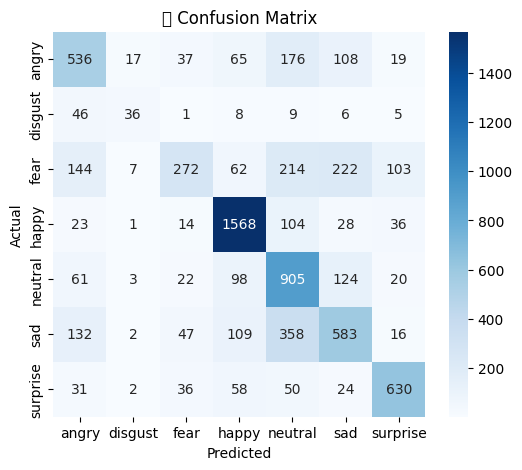

<Figure size 640x480 with 0 Axes>

In [ ]:

# 2. Prepare test data
# We only need the test generator for evaluation and prediction
_, _, test_gen = create_data_generators()
print("✅ Test data generator created.")

# 3. Evaluate the loaded model on the test set
print("\n--- Evaluating Loaded Model ---")
evaluate_model(loaded_model, test_gen)

# 4. Make predictions and analyze results with the loaded model
print("\n--- Making Predictions with Loaded Model ---")
predict_and_analyze(loaded_model, test_gen)


In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import io

# Assuming 'config' object and 'loaded_model' are already defined and accessible from previous cells.
# If not, you may need to run the cell where they are defined first.

def predict_single_image_from_upload(model, config):
    print("\n--- Upload Image for Prediction ---")
    uploaded = files.upload()

    if not uploaded:
        print("No file uploaded.")
        return

    # Get the name of the uploaded file
    for fn in uploaded.keys():
        print(f'User uploaded file "{fn}"')
        image_path = io.BytesIO(uploaded[fn])

        try:
            # Load and preprocess the image
            img = load_img(image_path, color_mode='grayscale', target_size=(config.IMG_HEIGHT, config.IMG_WIDTH))
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0) # Add batch dimension
            img_array = img_array / 255.0 # Rescale to 0-1

            # Make prediction
            predictions = model.predict(img_array)
            predicted_class_index = np.argmax(predictions[0])
            predicted_emotion = config.CLASSES[predicted_class_index]
            confidence = predictions[0][predicted_class_index] * 100

            # Display the image and prediction
            plt.figure(figsize=(4, 4))
            plt.imshow(img, cmap='gray')
            plt.title(f"Predicted Emotion: {predicted_emotion} ({confidence:.2f}%)")
            plt.axis('off')
            plt.show()

        except Exception as e:
            print(f"Error processing image {fn}: {e}")

# Call the function to test
# Ensure 'loaded_model' and 'config' are available from earlier execution.
# If you run this cell independently, make sure the cell defining loaded_model and config has been run.
if 'loaded_model' in locals() and 'config' in locals():
    predict_single_image_from_upload(loaded_model, config)
else:
    print("Error: 'loaded_model' or 'config' not found. Please run the previous cells first to load the model and define config.")


Error: 'loaded_model' or 'config' not found. Please run the previous cells first to load the model and define config.



--- Displaying 10 random test images with predictions ---


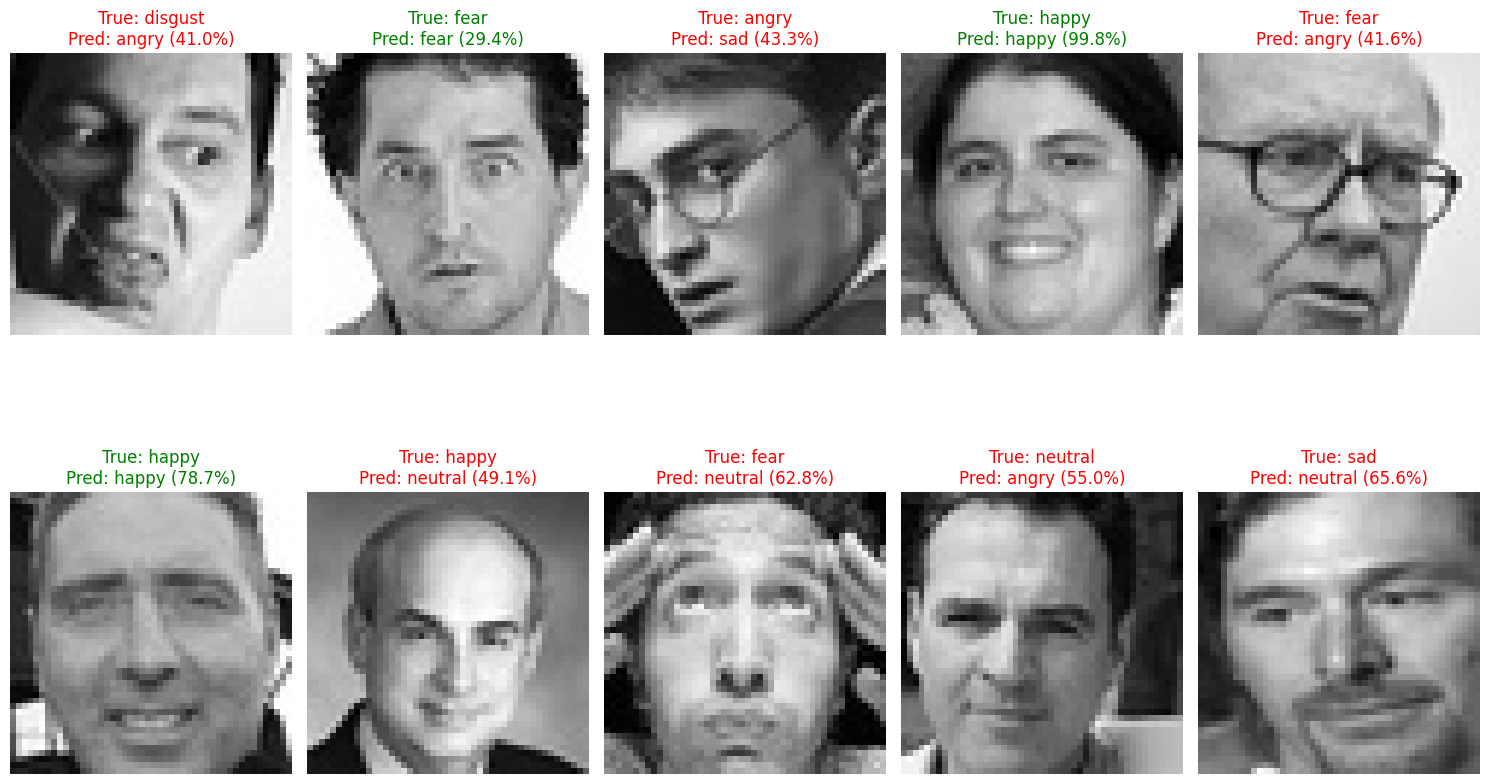

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Ensure 'loaded_model' and 'config' are available from earlier execution.
# If you run this cell independently, make sure the cell defining loaded_model and config has been run.
if 'loaded_model' not in locals() or 'config' not in locals():
    print("Error: 'loaded_model' or 'config' not found. Please run the previous cells first to load the model and define config.")
else:
    print("\n--- Displaying 10 random test images with predictions ---")

    TEST_DIR = os.path.join(config.data_dir, 'test')

    # Get all emotion classes from the test directory
    emotion_classes = sorted(os.listdir(TEST_DIR))

    # Collect paths of all test images
    all_test_image_paths = []
    for emotion in emotion_classes:
        emotion_path = os.path.join(TEST_DIR, emotion)
        if os.path.isdir(emotion_path):
            for img_name in os.listdir(emotion_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    all_test_image_paths.append((os.path.join(emotion_path, img_name), emotion))

    # Select 10 random images
    if len(all_test_image_paths) < 10:
        print(f"Warning: Only found {len(all_test_image_paths)} images. Displaying all available.")
        selected_images = random.sample(all_test_image_paths, len(all_test_image_paths))
    else:
        selected_images = random.sample(all_test_image_paths, 10)

    plt.figure(figsize=(15, 10))
    for i, (img_path, true_emotion) in enumerate(selected_images):
        try:
            # Load and preprocess the image
            img = load_img(img_path, color_mode='grayscale', target_size=(config.IMG_HEIGHT, config.IMG_WIDTH))
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
            img_array = img_array / 255.0  # Rescale to 0-1

            # Make prediction
            predictions = loaded_model.predict(img_array, verbose=0)
            predicted_class_index = np.argmax(predictions[0])
            predicted_emotion = config.CLASSES[predicted_class_index]
            confidence = predictions[0][predicted_class_index] * 100

            # Display the image and prediction
            plt.subplot(2, 5, i + 1)
            plt.imshow(img, cmap='gray')
            plt.title(f"True: {true_emotion}\nPred: {predicted_emotion} ({confidence:.1f}%)",
                      color='green' if true_emotion == predicted_emotion else 'red')
            plt.axis('off')
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")

    plt.tight_layout()
    plt.show()


## Phân tích quy trình huấn luyện và phân loại cảm xúc

Dựa trên các ô code đã cung cấp, đây là cách mô hình được huấn luyện và cách nó phân loại cảm xúc:

**1. Tổng quan quy trình:**

Quy trình diễn ra theo các bước chính sau:
*   **Cấu hình (Config):** Định nghĩa các tham số chung cho mô hình và quá trình huấn luyện.
*   **Chuẩn bị dữ liệu (Data Preparation):** Tải dữ liệu, tiền xử lý và áp dụng tăng cường dữ liệu (data augmentation).
*   **Xây dựng mô hình (Model Building):** Định nghĩa kiến trúc mạng CNN.
*   **Biên dịch mô hình (Compile Model):** Cấu hình thuật toán tối ưu hóa, hàm mất mát và các chỉ số đánh giá.
*   **Huấn luyện mô hình (Model Training):** Đào tạo mô hình trên dữ liệu huấn luyện và xác thực.
*   **Đánh giá & Phân tích (Evaluation & Analysis):** Kiểm tra hiệu suất mô hình trên dữ liệu kiểm tra và phân tích kết quả.
*   **Dự đoán ảnh đơn (Single Image Prediction):** Sử dụng mô hình đã huấn luyện để dự đoán cảm xúc từ một ảnh mới.

**2. Chi tiết từng bước:**

*   **`Config` (Cell E1-GduF7y0Sf và z5QFO2F-1dOF):**
    *   Lớp `Config` chứa tất cả các cài đặt quan trọng như: đường dẫn dữ liệu (`data_dir`), kích thước ảnh (`IMG_HEIGHT`, `IMG_WIDTH`, `IMG_CHANNELS`), kích thước batch (`BATCH_SIZE`), số epoch (`EPOCHS`), tốc độ học (`LEARNING_RATE`), các lớp cảm xúc (`CLASSES`) và đường dẫn lưu mô hình/trọng số.
    *   Các giá trị này sẽ được sử dụng xuyên suốt quá trình huấn luyện và đánh giá.

*   **`create_data_generators()` (Cell 3XG1SnRlzGRP và z5QFO2F-1dOF):**
    *   Hàm này sử dụng `ImageDataGenerator` của Keras để tải và tiền xử lý dữ liệu ảnh.
    *   **Tăng cường dữ liệu (Data Augmentation):** Đối với tập huấn luyện, `ImageDataGenerator` áp dụng các phép biến đổi ngẫu nhiên như xoay (rotation), dịch chuyển (shift), cắt xén (shear), lật ngang (horizontal flip) để tạo ra các biến thể của ảnh gốc. Điều này giúp mô hình học cách tổng quát hóa tốt hơn và giảm overfitting.
    *   **Tiền xử lý:** Rescale giá trị pixel từ 0-255 về 0-1.
    *   **Tạo Generators:** Tạo ra các `train_generator`, `validation_generator` và `test_generator` giúp load dữ liệu theo từng batch hiệu quả, đặc biệt với các tập dữ liệu lớn không thể chứa hết trong bộ nhớ.

*   **`build_cnn_model()` (Cell lrwaRl43zGyn):**
    *   Hàm này định nghĩa kiến trúc của Mạng nơ-ron tích chập (CNN) sẽ được sử dụng.
    *   Mô hình là một chuỗi (`Sequential`) các lớp:
        *   **`Conv2D`:** Các lớp tích chập để trích xuất đặc trưng từ ảnh.
        *   **`BatchNormalization`:** Giúp ổn định quá trình huấn luyện bằng cách chuẩn hóa các đầu ra của lớp trước đó.
        *   **`MaxPooling2D`:** Giảm kích thước không gian của các bản đồ đặc trưng, giúp giảm số lượng tham số và tăng tốc độ tính toán.
        *   **`Dropout`:** Ngẫu nhiên bỏ qua một số nơ-ron trong quá trình huấn luyện để ngăn ngừa overfitting.
        *   **`Flatten`:** Chuyển đổi đầu ra từ các lớp tích chập thành một vector 1D.
        *   **`Dense`:** Các lớp fully connected (kết nối đầy đủ) để học các mối quan hệ phức tạp và đưa ra quyết định phân loại.
        *   **`softmax` (Output Layer):** Lớp đầu ra với hàm kích hoạt softmax, cho ra xác suất thuộc về từng lớp cảm xúc.

*   **`compile_model()` (Cell 8AeL403BzMaf):**
    *   Biên dịch mô hình bằng cách xác định:
        *   **Optimizer (Trình tối ưu hóa):** `Adam` được sử dụng với `learning_rate` xác định trong `Config`. Trình tối ưu hóa điều chỉnh trọng số của mô hình để giảm thiểu hàm mất mát.
        *   **Loss Function (Hàm mất mát):** `categorical_crossentropy` được sử dụng cho bài toán phân loại đa lớp (multi-class classification). Hàm này đo lường sự khác biệt giữa phân phối xác suất dự đoán và phân phối xác suất thực tế.
        *   **Metrics (Chỉ số đánh giá):** `accuracy` (độ chính xác), `Precision` (độ chính xác), `Recall` (độ thu hồi) và `AUC` (diện tích dưới đường cong ROC) được theo dõi trong quá trình huấn luyện để đánh giá hiệu suất của mô hình.

*   **`create_callbacks()` (Cell vCCfQCXzzPHO):**
    *   Các callback là các hàm được gọi tại các điểm khác nhau trong quá trình huấn luyện để thực hiện các tác vụ như:
        *   **`ModelCheckpoint`:** Lưu mô hình có `val_accuracy` tốt nhất.
        *   **`ReduceLROnPlateau`:** Giảm `learning_rate` nếu `val_loss` không cải thiện sau một số epoch nhất định.
        *   **`EarlyStopping`:** Dừng huấn luyện sớm nếu `val_loss` không cải thiện, để ngăn chặn overfitting và khôi phục lại trọng số của mô hình tốt nhất.
        *   **`CSVLogger`:** Lưu lại lịch sử huấn luyện vào một file CSV.

*   **`train_model()` (Cell mFVvm0VBzPyf):**
    *   Hàm này thực hiện quá trình huấn luyện mô hình bằng cách gọi `model.fit()`.
    *   Mô hình được huấn luyện trên `train_generator`, xác thực trên `validation_generator` và sử dụng các `callbacks` đã định nghĩa.
    *   Lịch sử huấn luyện (loss, accuracy, v.v. cho cả tập train và validation) được lưu lại và sau đó vẽ biểu đồ để dễ dàng theo dõi sự thay đổi qua các epoch.

*   **`evaluate_model()` (Cell CG9oRYOWzUDP và z5QFO2F-1dOF):**
    *   Sau khi huấn luyện, hàm này đánh giá hiệu suất cuối cùng của mô hình trên tập `test_generator` (dữ liệu kiểm tra mà mô hình chưa từng thấy).
    *   Nó in ra các chỉ số như loss, accuracy, precision, recall, và AUC trên tập kiểm tra.

*   **`predict_and_analyze()` (Cell GMPzudkFzRc3 và z5QFO2F-1dOF):**
    *   Hàm này thực hiện dự đoán trên tập `test_generator`.
    *   **`classification_report`:** Hiển thị chi tiết các chỉ số precision, recall, f1-score và support cho từng lớp cảm xúc.
    *   **`confusion_matrix`:** Vẽ biểu đồ ma trận nhầm lẫn, cho thấy số lượng mẫu được phân loại đúng/sai giữa các lớp, giúp bạn hiểu rõ mô hình nhầm lẫn giữa các cảm xúc nào.

*   **`predict_single_image_from_upload()` (Cell OLB-1snH4IPM):**
    *   Chức năng này cho phép bạn tải lên một hình ảnh từ máy tính của mình.
    *   Ảnh được tải lên sẽ được tiền xử lý (chuyển sang thang độ xám, thay đổi kích thước, chuẩn hóa) để phù hợp với định dạng đầu vào của mô hình.
    *   Mô hình `loaded_model` sau đó sẽ đưa ra dự đoán về cảm xúc trong ảnh.
    *   Kết quả dự đoán (cảm xúc và độ tin cậy) cùng với hình ảnh sẽ được hiển thị.

**Tóm lại:**

Mô hình được huấn luyện bằng cách sử dụng mạng CNN để học các đặc trưng từ ảnh khuôn mặt. Quá trình này được hỗ trợ bởi tăng cường dữ liệu và các kỹ thuật điều chỉnh như Batch Normalization và Dropout để cải thiện hiệu suất. Sau khi huấn luyện, mô hình có thể phân loại cảm xúc bằng cách xử lý ảnh đầu vào và đưa ra dự đoán xác suất cho từng loại cảm xúc.